# Восстановление золота из руды

Необходимо подготовить проект модели машинного обучения.  
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используются данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


Данные находятся в трёх файлах:

`gold_recovery_train_new.csv` — обучающая выборка;

`gold_recovery_test_new.csv` — тестовая выборка;

`gold_recovery_full_new.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
Обучающая и тестовая выборки являются выгрузкой из исходных данных. 

**Описание данных**

*Технологический процесс*

Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

Xanthate — ксантогенат (промотер, или активатор флотации);

Sulphate — сульфат (на данном производстве сульфид натрия);

Depressant — депрессант (силикат натрия).

Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота

*Параметры этапов*

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

*Наименование признаков*

Структура наименования признаков:

этап.тип_параметра.название_параметра

Возможные значения для блока "этап":
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока "тип_параметра":
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

В качестве метрики качества будем использовать sMAPE (Symmetric Mean Absolute Percentage Error).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

$$sMAPE = \frac {1} {N} \sum\limits_{i=1}^N \frac {|y_i-\hat y_i|} {(|y_i|+|\hat y_i|)/2} * 100 \% $$

Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

$$итоговая\ sMAPE = 25\% * sMAPE(rougher) + 75\%*sMAPE(final)$$

## Подготовка данных

In [1]:
RANDOM_STATE = 111

In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV)
from sklearn.metrics import make_scorer
import warnings

### Изучение данных

In [3]:
# Загрузим данные в датафреймы:
try:
    full_df = pd.read_csv('/datasets/gold_recovery_full_new.csv')    
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
    full_df = pd.read_csv('gold_recovery_full_new.csv')    
    train = pd.read_csv('gold_recovery_train_new.csv')
    test = pd.read_csv('gold_recovery_test_new.csv')

Посмотрирм размерность датафреймов.

In [4]:
train.shape

(14149, 87)

In [5]:
test.shape

(5290, 53)

In [6]:
full_df.shape

(19439, 87)

Количество строк в исходной таблице равно сумме количества строк в таблицах `train`  и `test`.

Посмотрим на данные.

In [7]:
full_df.sample(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
16497,2018-03-24 11:59:59,5.536819,11.586638,6.977085,44.148286,76.166100,9.750288,2.139407,8.316571,2.085715,...,23.039403,-502.231821,15.090444,-500.508067,17.984543,-500.351279,12.017706,-500.005882,13.016542,-499.939417
15370,2018-02-01 03:59:59,6.889695,10.188635,10.716281,43.567488,73.492237,14.497056,3.633364,11.215520,4.110800,...,19.984042,-500.803242,15.014377,-500.101181,10.942039,-500.548852,8.932772,-500.103692,10.977238,-500.481019
15235,2018-01-19 02:59:59,3.105306,9.930730,14.200236,47.255208,62.551036,9.760748,2.252695,4.533010,3.208246,...,20.027434,-499.933807,15.037887,-499.491106,10.939509,-499.979300,9.032660,-499.876832,10.994648,-499.923280
16235,2018-03-12 13:59:59,5.656570,9.726533,8.954620,44.880490,74.518029,11.061992,1.496503,9.023083,2.301876,...,22.973803,-500.420336,15.019479,-499.816044,17.950784,-500.202927,12.026778,-499.772788,11.996716,-499.531702
12827,2017-09-23 11:59:59,3.852523,11.479554,6.574178,46.915014,79.656115,5.016139,2.415050,8.489279,1.929435,...,11.972561,-500.028105,8.978868,-398.825425,9.090791,-499.539689,6.944736,-499.719654,10.013730,-499.222253


Преобразуем столбцы `date` в формат 'datetime'

In [8]:
full_df['date'] = pd.to_datetime(full_df['date'])

test['date'] = pd.to_datetime(test['date'])

train['date'] = pd.to_datetime(train['date'])

Посмотрим, как разделены тренировочные и тестовые данные по датам.

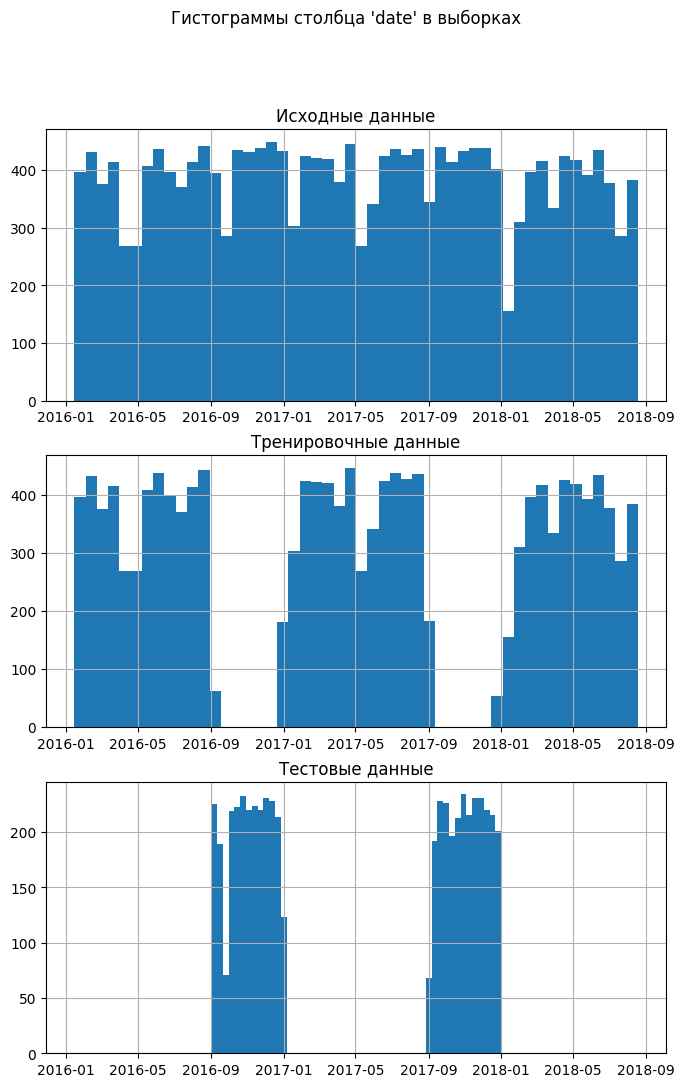

In [9]:
# построим гистограммы
plt.figure(figsize = (8,12))
plt.suptitle("Гистограммы столбца 'date' в выборках")
plt.subplot(311)
ax = full_df.date.hist(bins = 50)
plt.title('Исходные данные')
plt.subplot(312)
train.date.hist(bins = 50)
plt.xlim(ax.get_xlim())
plt.title('Тренировочные данные')
plt.subplot(313)
test.date.hist(bins = 50)
plt.xlim(ax.get_xlim())
plt.title('Тестовые данные');

Из гистограмм можно предположить, что данные между тестовой и тренировочной выборками распределялись не слусайным образом, а по периодам.

Проверим даты на дубликаты.

In [10]:
full_df['date'].duplicated().sum()

0

Дубликатов нет. Значит можно ипользовать этот столбец в качестве индекса.

In [11]:
# изменение индексов в датафреймах
full_df = full_df.set_index('date')
train = train.set_index('date')
test = test.set_index('date')

### Проверка расчета эффективности обогащения

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Эффективность восстановления рассчитывается по формуле:

$$Recovery = \frac {C(F-T)} {F(C-T)}$$ где  

C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.

In [12]:
full_df['rougher.output.recovery_calc'] = (
    full_df['rougher.output.concentrate_au'] * 
    (full_df['rougher.input.feed_au'] - full_df['rougher.output.tail_au']) /
    (full_df['rougher.input.feed_au'] * (full_df['rougher.output.concentrate_au'] 
    - full_df['rougher.output.tail_au']))) *100

In [13]:
full_df[['rougher.output.recovery_calc', 'rougher.output.recovery']].head()

,rougher.output.recovery_calc,rougher.output.recovery
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794


Найдеме MAE между полученными значениями и значениями признака.

In [14]:
abs(full_df['rougher.output.recovery_calc'] - train['rougher.output.recovery']).mean()

9.737383310755772e-15

**Вывод.**

**Значение MAE очень мало, следовательно эффективность обогащения рассчитана верно.**

### Анализ признаков, недоступных в тестовой выборке

Рассмотрим типы параметров, которые присутствуют в разных выборках.

In [15]:
# получим параметры, отсутствующие в тестовой выборке
dropped_columns = train.columns.drop(test.columns)

In [16]:
def type_count(df_col):
    """
    Функция подсчитывает количество параметров различных типов
    """
    types = ['input', 'output', 'state', 'calculation']
    for type in types:
        print(f'Количество параметров типа {type}:', 
              sum(map(lambda x: type in x, df_col)))

Для тренировочной и полной выборок

In [17]:
type_count(train.columns)

Количество параметров типа input: 14
Количество параметров типа output: 30
Количество параметров типа state: 38
Количество параметров типа calculation: 4


Для тестовой выборки

In [18]:
type_count(test.columns)

Количество параметров типа input: 14
Количество параметров типа output: 0
Количество параметров типа state: 38
Количество параметров типа calculation: 0


Для удаленных параметров

In [19]:
type_count(dropped_columns)

Количество параметров типа input: 0
Количество параметров типа output: 30
Количество параметров типа state: 0
Количество параметров типа calculation: 4


Мы видим, что в тестовую выборку не попали параметры, которые либо являются расчетными, либо измеряются по окончании очередного этапа обработки.

### Предобработка данных

В выборках есть пропуски. Поскольку тренировочная и тестовая выборки сформированы из исходной, посмотрим доли пропусков в выборке `full_df`

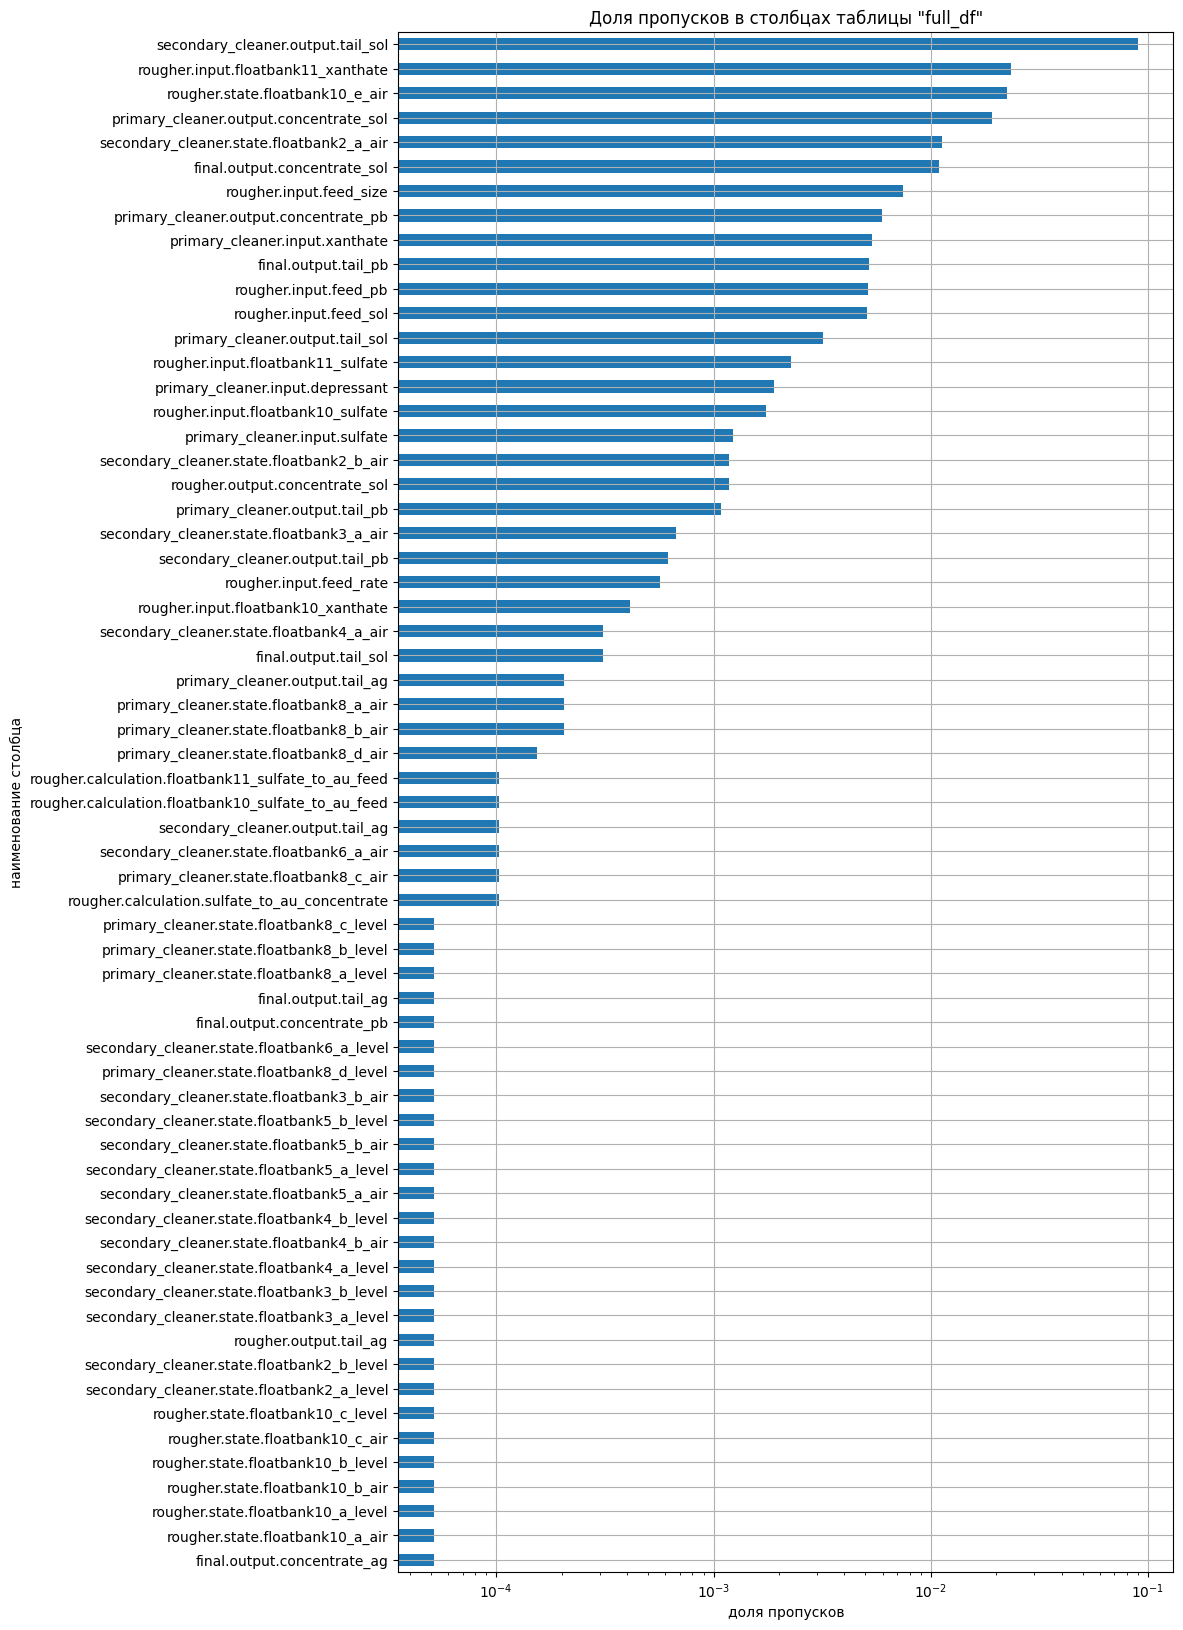

In [20]:
# визуолизируем доли пропусков в параметрах
ax = full_df.isna().mean()[full_df.isna().mean() > 0].sort_values().plot(kind = 'barh', 
                                                      figsize = (10, 20), grid = True)
plt.title('Доля пропусков в столбцах таблицы "full_df"')
plt.xlabel('доля пропусков')
plt.ylabel('наименование столбца')
ax.set_xscale('log');

В задании указано, что соседние значения  параметров близкие, поэтому заполним пропущенные значения по предыдущим заполненным.

In [21]:
#заполняем пропуски в таблице "test"
test = test.fillna(method='ffill')

print('Пропусков после заполнения тестовой выборки:', test.isna().sum().sum())
print('Размерность таблицы "test":', test.shape)

Пропусков после заполнения тестовой выборки: 0
Размерность таблицы "test": (5290, 52)


In [22]:
#заполняем пропуски в таблице "train"
train = train.fillna(method='ffill')

print('Пропусков после заполнения тренировочной выборки:', train.isna().sum().sum())
print('Размерность таблицы "train":', train.shape)

Пропусков после заполнения тренировочной выборки: 0
Размерность таблицы "train": (14149, 86)


Добавим в тестовую таблицу целевые признаки.

In [23]:
test['final.output.recovery'] = full_df['final.output.recovery']
test['rougher.output.recovery'] = full_df['rougher.output.recovery']

print('Размерность таблицы "test":', test.shape)

Размерность таблицы "test": (5290, 54)


Обработка данных прошла корректно. Пропусков не осталось, размерности таблиц имеют требуемые значения.

### Выводы

При подготовке данных были установлены следующие факты:
- Датафрейм с исходными данными `full_df` разбит на тренировочную и тестовую выборки
- Разбиение проводилось по временным периодам. Три периода вошли в тренировочную выборку, два - в тестовую.
- В тестовую выборку не вошли вычисляемые параметры и параметры, получаемые по окончании процессов.
- Эффективность обогащения рассчитана верно.

В ходе предварительной обработки были заполнены пропуски. При заполнении использовался метод заполнения ближайшим предыдущим значением.

В тестовую выборку добавлены целевые признаки.

## Анализ данных

### Исследование изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

Рассмотрим концентрацию металлов в руде, концентратах и хвостах на разных этапах очистки. 

**Концентрация золота**

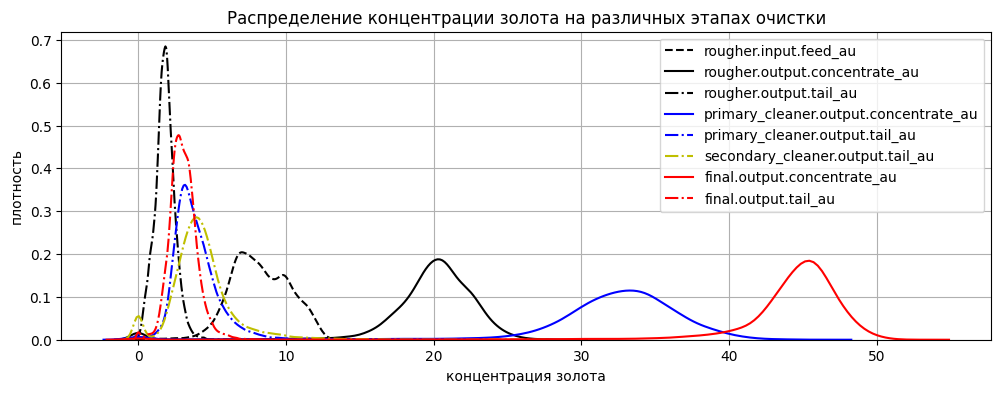

In [24]:
# составляем список параметров, показывающих концентрацию металла
features = ['rougher.input.feed_au', 'rougher.output.concentrate_au',  'rougher.output.tail_au',
           'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au', 
            'secondary_cleaner.output.tail_au', 'final.output.concentrate_au', 
            'final.output.tail_au']
# задаем цвета графиков
colors = ['k','k','k','b','b','y','r','r']
# задаем стили графиков
linestyles = ['dashed', 'solid','dashdot', 'solid', 'dashdot', 'dashdot', 'solid','dashdot']

plt.figure(figsize = (12,4))
for feature, color, linestyle in zip(features, colors, linestyles):
    sns.kdeplot(data = full_df, x = feature, color = color, linestyle = linestyle)
plt.legend(features)
plt.grid()
plt.title('Распределение концентрации золота на различных этапах очистки')
plt.xlabel('концентрация золота')
plt.ylabel('плотность');


**Концентрация серебра**

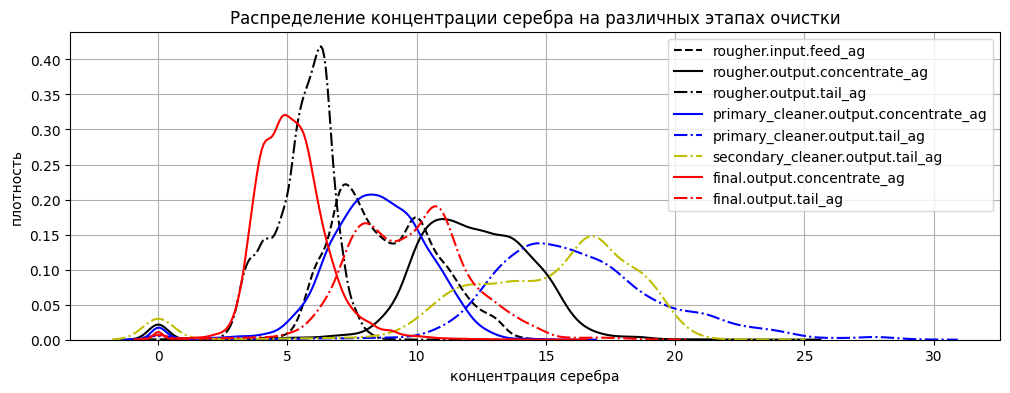

In [25]:
# составляем список параметров, показывающих концентрацию металла
features = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'rougher.output.tail_ag', 
           'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.tail_ag', 
            'secondary_cleaner.output.tail_ag', 'final.output.concentrate_ag', 'final.output.tail_ag']
# задаем цвета графиков
colors = ['k','k','k','b','b','y','r','r']
# задаем стили графиков
linestyles = ['dashed', 'solid','dashdot', 'solid', 'dashdot', 'dashdot', 'solid','dashdot']

plt.figure(figsize = (12,4))
for feature, color, linestyle in zip(features, colors, linestyles):
    sns.kdeplot(data = full_df, x = feature, color = color, linestyle = linestyle)
plt.legend(features)
plt.grid()
plt.title('Распределение концентрации серебра на различных этапах очистки')
plt.xlabel('концентрация серебра')
plt.ylabel('плотность');


**Концентрация свинца**

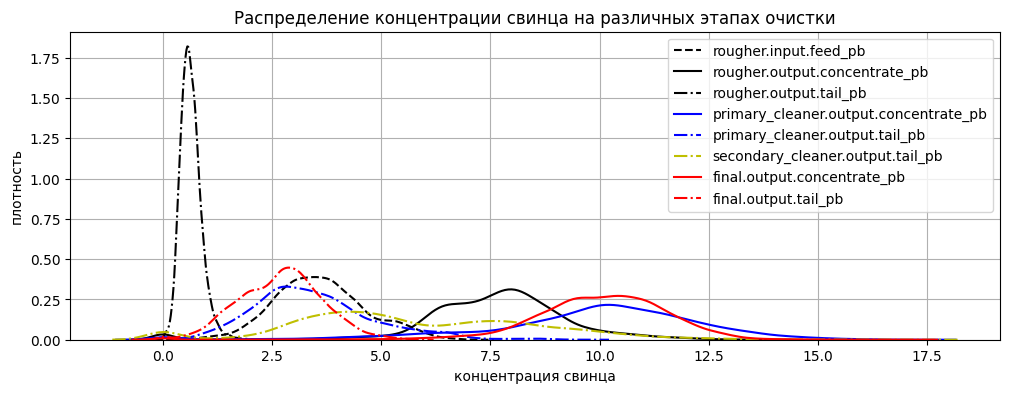

In [26]:
# составляем список параметров, показывающих концентрацию металла
features = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'rougher.output.tail_pb', 
           'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.tail_pb', 
            'secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb', 
            'final.output.tail_pb']
# задаем цвета графиков
colors = ['k','k','k','b','b','y','r','r']
# задаем стили графиков
linestyles = ['dashed', 'solid','dashdot', 'solid', 'dashdot', 'dashdot', 'solid','dashdot']

plt.figure(figsize = (12,4))
for feature, color, linestyle in zip(features, colors, linestyles):
    sns.kdeplot(data = full_df, x = feature, color = color, linestyle = linestyle)
plt.legend(features)
plt.grid()
plt.title('Распределение концентрации свинца на различных этапах очистки')
plt.xlabel('концентрация свинца')
plt.ylabel('плотность');

Из графиков видно, что концентрация золота и свинца в концентрате увеличивается на каждом этапе очистки, а серебра, наоборот, уменьшается.

Рассмотрим среднюю концентрацию металлов в концентрате и хвостах на разных этапах.

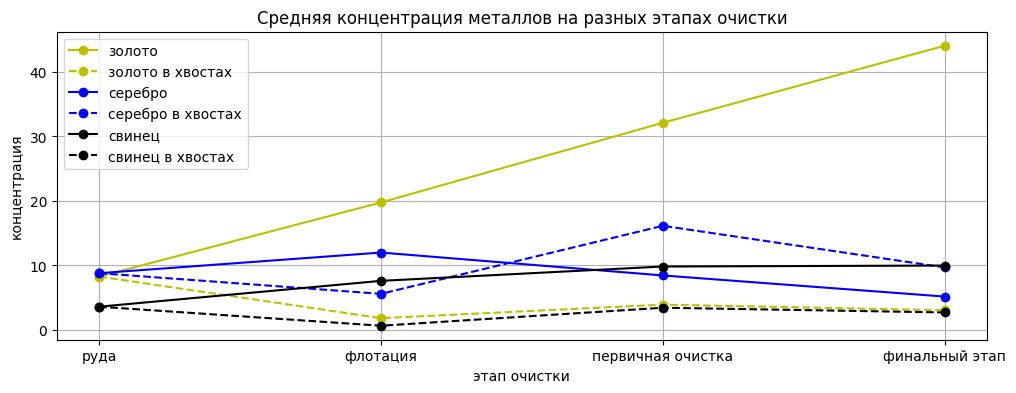

In [27]:
features_au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 
               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
features_au_tails = ['rougher.input.feed_au', 'rougher.output.tail_au',
                     'primary_cleaner.output.tail_au', 'final.output.tail_au']
features_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
               'primary_cleaner.output.concentrate_ag', 
               'final.output.concentrate_ag']
features_ag_tails = ['rougher.input.feed_ag', 'rougher.output.tail_ag',
                     'primary_cleaner.output.tail_ag', 'final.output.tail_ag']
features_pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
               'primary_cleaner.output.concentrate_pb', 
               'final.output.concentrate_pb']
features_pb_tails = ['rougher.input.feed_pb', 'rougher.output.tail_pb',
                     'primary_cleaner.output.tail_pb',
                     'final.output.tail_pb']
pd.concat(
    [full_df[features_au].mean().reset_index(drop = True), 
           full_df[features_au_tails].mean().reset_index(drop = True),
           full_df[features_ag].mean().reset_index(drop = True),
           full_df[features_ag_tails].mean().reset_index(drop = True),
           full_df[features_pb].mean().reset_index(drop = True),
           full_df[features_pb_tails].mean().reset_index(drop = True)], 
           axis = 1).set_index([['руда', 'флотация', 'первичная очистка', 'финальный этап']]
        ).plot(style = ['yo-', 'yo--', 'bo-', 'bo--', 'ko-', 'ko--'], figsize = (12,4))
plt.xticks ([0,1,2,3])
plt.grid()
plt.title('Средняя концентрация металлов на разных этапах очистки')
plt.legend(['золото', 'золото в хвостах', 'серебро', 'серебро в хвостах', 'свинец', 
            'свинец в хвостах'])
plt.xlabel('этап очистки')
plt.ylabel('концентрация');

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

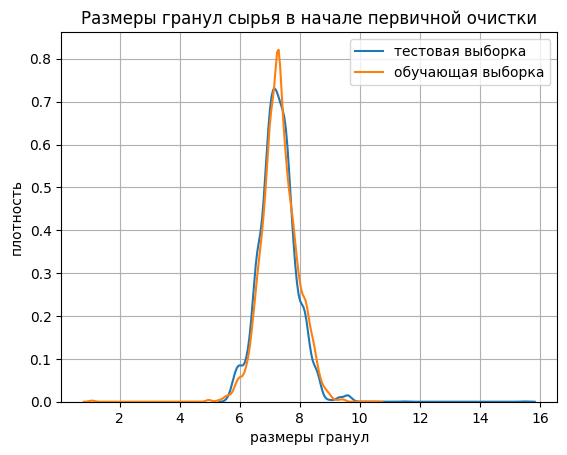

In [28]:
sns.kdeplot(data = test, x = 'primary_cleaner.input.feed_size')
sns.kdeplot(data = train, x = 'primary_cleaner.input.feed_size')
plt.grid()
plt.title("Размеры гранул сырья в начале первичной очистки")
plt.xlabel('размеры гранул')
plt.ylabel('плотность')
plt.legend(['тестовая выборка', 'обучающая выборка']);

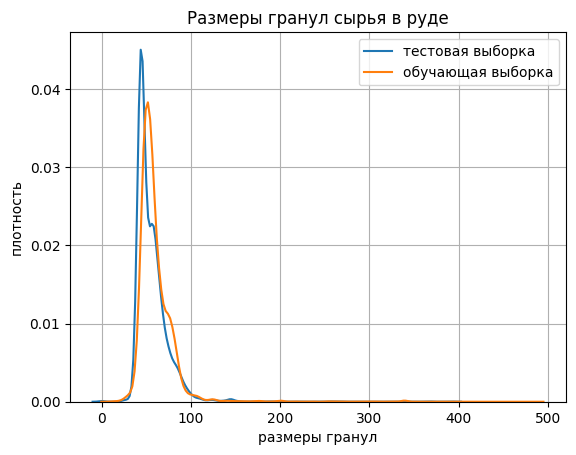

In [29]:
sns.kdeplot(data = test, x = 'rougher.input.feed_size')
sns.kdeplot(data = train, x = 'rougher.input.feed_size')
plt.grid()
plt.title("Размеры гранул сырья в руде")
plt.xlabel('размеры гранул')
plt.ylabel('плотность')
plt.legend(['тестовая выборка', 'обучающая выборка']);

Распределение размеров гранул близкие. Можно использовать в моделировании.

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [30]:
# концентрация в руде
ore = (full_df['rougher.input.feed_au'] + full_df['rougher.input.feed_ag'] + 
       full_df['rougher.input.feed_pb'])
# концентрация в начале очистки
rougher = (full_df['rougher.output.concentrate_au'] + full_df['rougher.output.concentrate_ag'] + 
            full_df['rougher.output.concentrate_pb'])
# финальная концентрация
final = (full_df['final.output.concentrate_au'] + full_df['final.output.concentrate_ag'] + 
            full_df['final.output.concentrate_pb'])

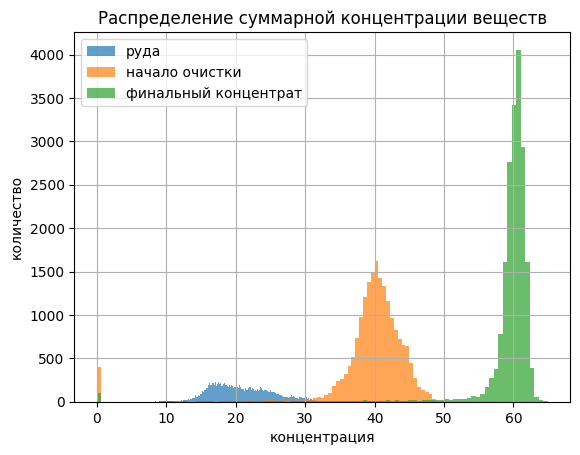

In [31]:
# постпоение графиков
ore.hist(bins = 300, alpha = 0.7, )
rougher.hist(bins = 100, alpha = 0.7)
final.hist(bins = 100, alpha = 0.7)
plt.title("Распределение суммарной концентрации веществ")
plt.xlabel('концентрация')
plt.ylabel('количество')
plt.legend(['руда', 'начало очистки', 'финальный концентрат']);

Посмотрим на гистограммы концентраций металлов.

In [32]:
# признаки с концентрацией металлов
columns_conc = full_df.columns[((full_df.columns.str.contains('input.feed_')) | 
                                (full_df.columns.str.contains('output.concentrate_')))
               & (full_df.columns.str.contains('au') | full_df.columns.str.contains('ag')
               | full_df.columns.str.contains('pb'))
               ]

In [33]:
# признаки с концентрацией металлов в тестовой выборке
columns_conc_test = full_df.columns[(full_df.columns.str.contains('input.feed_') )
               & (full_df.columns.str.contains('au') | full_df.columns.str.contains('ag')
               | full_df.columns.str.contains('pb'))
               ]

In [34]:
columns_conc_test

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_au'],
      dtype='object')

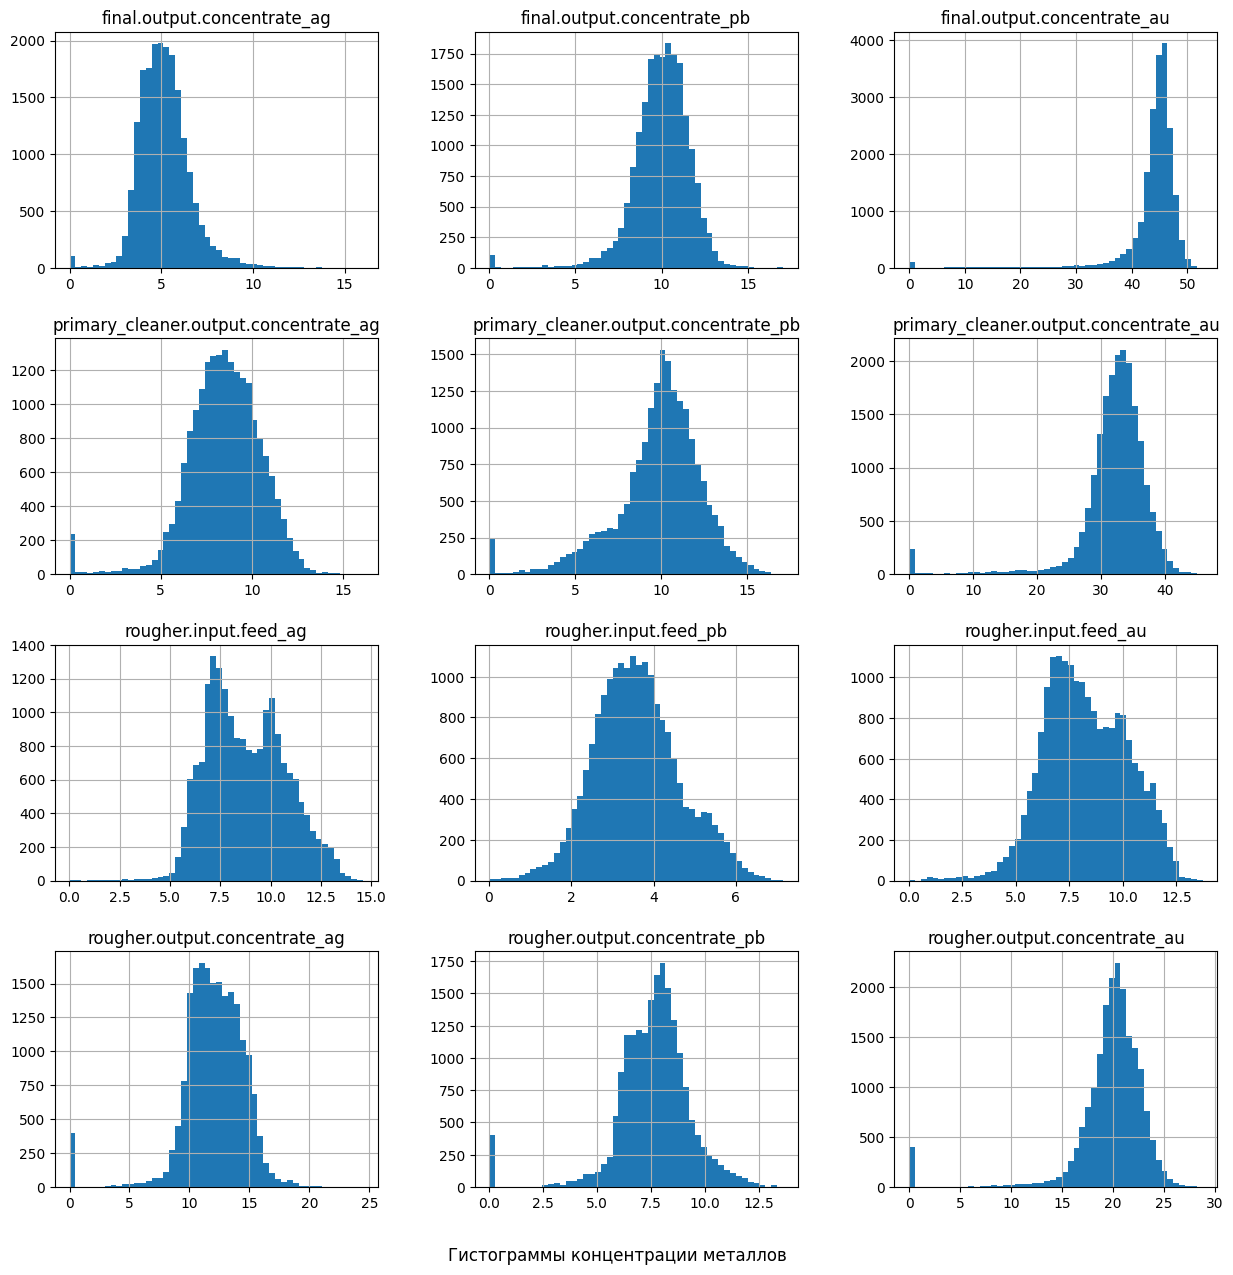

In [35]:
# построение гистограмм
full_df[columns_conc].hist(bins = 50, figsize = (15,15))
plt.suptitle("Гистограммы концентрации металлов", y = 0.07);

На гистограммах видны выбросы в районе нуля. Уберем их.

In [36]:
print(f'Размер данных до удаления: {train.shape}')
for column in columns_conc:
    train = train[train[column] > 1]
print(f'Размер данных после удаления: {train.shape}')

Размер данных до удаления: (14149, 86)
Размер данных после удаления: (13436, 86)


Снова посмотрим на гистограммы.

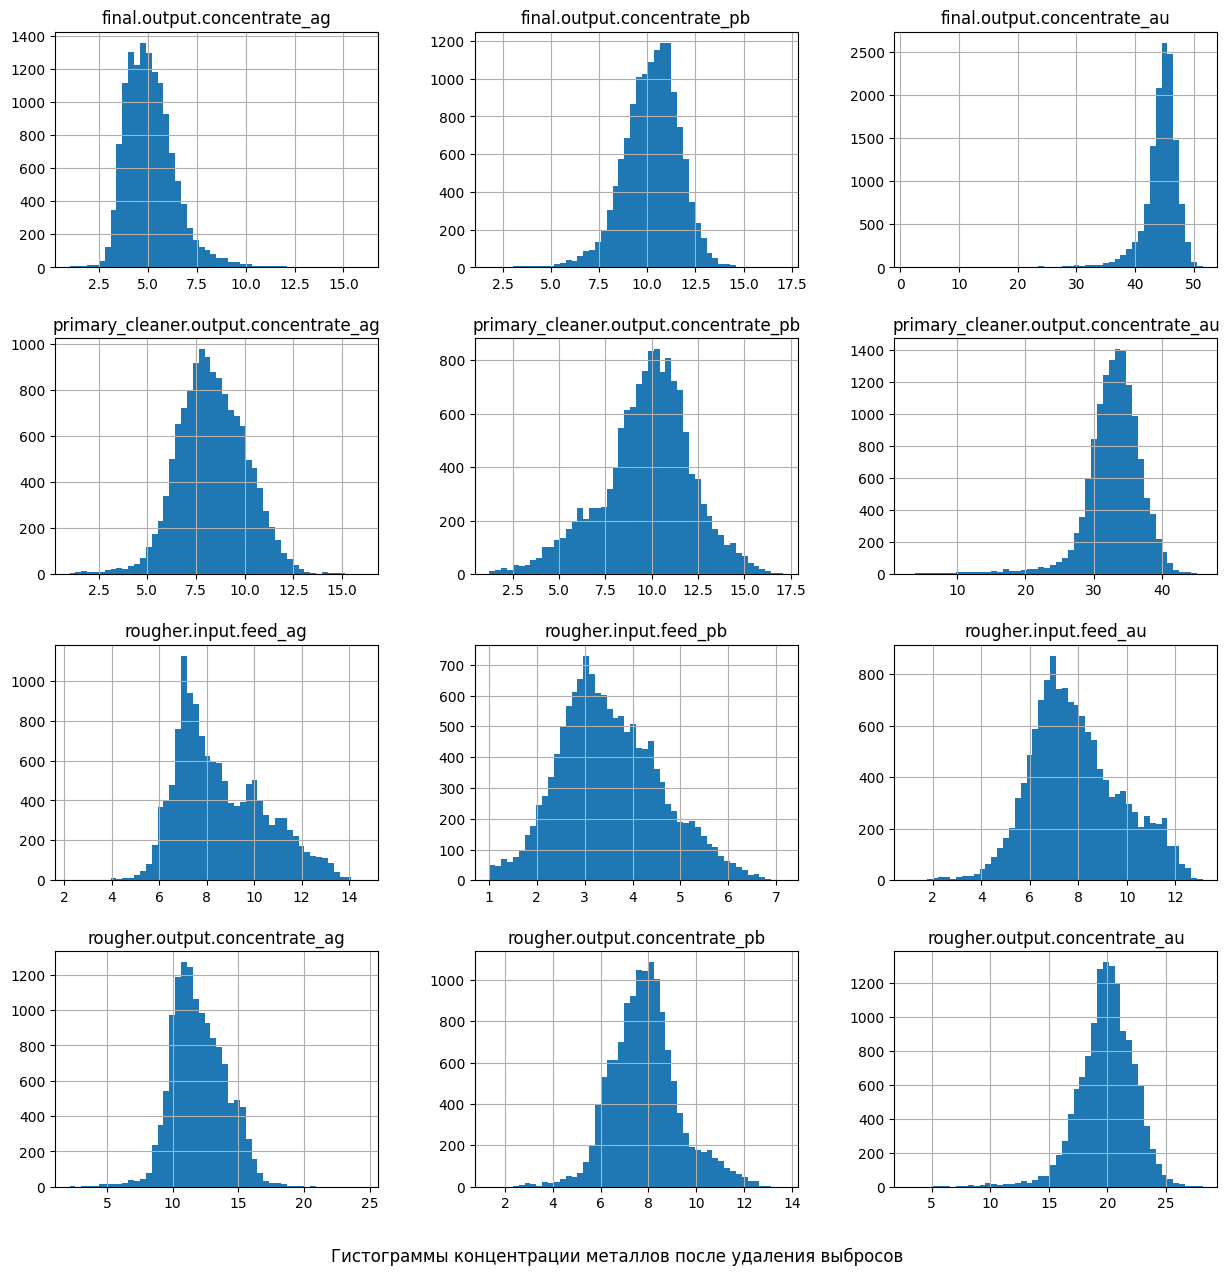

In [37]:
train[columns_conc].hist(bins = 50, figsize = (15,15))
plt.suptitle("Гистограммы концентрации металлов после удаления выбросов", y = 0.07);

Выбросы исчезли.

Посмотрим на гистограммы целевых признаков.

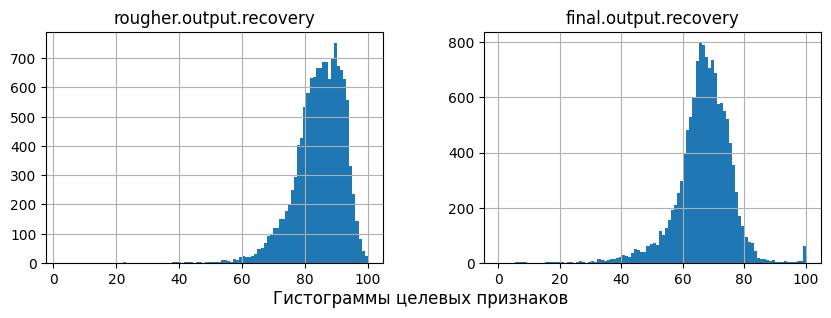

In [38]:
train[['rougher.output.recovery', 'final.output.recovery']].hist(bins = 100, figsize = (10,3))
plt.suptitle("Гистограммы целевых признаков", y = 0.02);

Признак `final.output.recovery` имеет выбросы в районе 100. Уберем их.

In [39]:
print(f'Размер данных до удаления: {train.shape}')
train = train[train['final.output.recovery'] <= 99]
print(f'Размер данных после удаления: {train.shape}')

Размер данных до удаления: (13436, 86)
Размер данных после удаления: (13376, 86)


Убедимся, что выбросы исчезли.

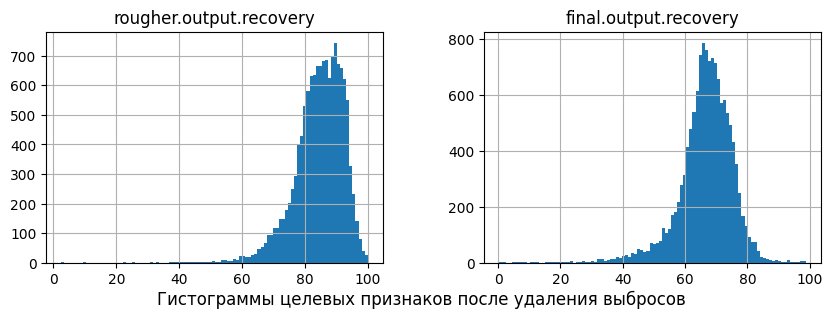

In [40]:
train[['rougher.output.recovery', 'final.output.recovery']].hist(bins = 100, figsize = (10,3))
plt.suptitle("Гистограммы целевых признаков после удаления выбросов", y = 0.02);

### Выводы

В ходе анализа данных выявлены следующие факты:
- Концентрация золота и свинца в концентрате увеличивается на каждом этапе очистки, а серебра, наоборот, уменьшается. Серебро переходит в "хвосты".
- Распределение размеров гранул в обучающей и тестовой выборках близкие. Данные можно использовать в моделировании.
- Суммарная концентрация металлов в концентрате увеличивается на каждом посдедующем этапе.

Были удалены выбросы в данных (773 строки), что составляет 5,5 %.

## Модель

Создадим две модели. Первая будет предсказывать эффективность обогащения на этапе флотации. Вторая - на финальном этапе. Каждая из моделей должна принимать признаки, доступные к началу соответствующего этапа.

### Подготовка к моделированию

In [41]:
# столбцы признаков для этапа флотации
train_rougher_columns = test.columns[test.columns.str.contains('rougher')]
train_rougher_columns.shape

(23,)

In [42]:
# обучающие признаки для этапа флотации
features_train_rougher = train[train_rougher_columns].drop(columns = ['rougher.output.recovery'])
features_train_rougher.shape

(13376, 22)

In [43]:
# обучающие целевые признаки для этапа флотации
target_train_rougher = train['rougher.output.recovery']
target_train_rougher.shape

(13376,)

In [44]:
# тестовые признаки для этапа флотации
features_test_rougher = test[train_rougher_columns].drop(columns = ['rougher.output.recovery'])
features_test_rougher.shape

(5290, 22)

In [45]:
# тестовые целевые признаки для этапа флотации
target_test_rougher = test['rougher.output.recovery']
target_test_rougher.shape

(5290,)

In [46]:
# обучающие признаки для финального этапа
features_train_final = train[test.columns].drop(columns = ['rougher.output.recovery',
                                                           'final.output.recovery'])

features_train_final.shape

(13376, 52)

In [47]:
# обучающие целевые признаки для финальног этапа
target_train_final = train['final.output.recovery']
target_train_final.shape

(13376,)

In [48]:
# тестовые признаки для финального этапа
features_test_final = test.drop(columns = ['rougher.output.recovery', 'final.output.recovery'])
features_test_final.shape

(5290, 52)

In [49]:
# тестовые целевые признаки для финального этапа
target_test_final = test['final.output.recovery']
target_test_final.shape

(5290,)

Стандартизируем признаки

In [50]:
# инициализация модели стандартизации
scaler = StandardScaler()

In [51]:
# обучение модели и стандартизация обучающих признаков для прервого этапа
features_train_rougher = pd.DataFrame(scaler.fit_transform(features_train_rougher), 
                                      index = features_train_rougher.index,
                                      columns = features_train_rougher.columns)

# стандартизация тестовых признаков для прервого этапа
features_test_rougher = pd.DataFrame(scaler.transform(features_test_rougher), 
                                     index = features_test_rougher.index,
                                     columns = features_test_rougher.columns)

# обучение модели и стандартизация обучающих признаков для второго этапа
features_train_final = pd.DataFrame(scaler.fit_transform(features_train_final), 
                                    index = features_train_final.index,
                                    columns = features_train_final.columns)

# стандартизация тестовых признаков для второго этапа
features_test_final = pd.DataFrame(scaler.transform(features_test_final), 
                                   index = features_test_final.index,
                                   columns = features_test_final.columns)

Напишем функцию для расчета метрики sMAPE.

In [52]:
def sMAPE(target, predict):
    """
    Функция расчета sMAPE
    """
    smape = np.mean(abs(target - predict) * 2 / (abs(target) + abs(predict))) * 100
    return smape

Создадим функцию для высчисления итоговой sMAPE   

In [53]:
def total_metric(m1, m2, w1 = 0.25, w2 = 0.75):
    """
    Функция для расчета итоговой метрики.
    Аргументы:
    m1 - первая метрика
    m2 - вторая метрика
    w1 - вес m1
    w2 - вес m2
    """
    return w1 * m1 + w2 * m2

In [54]:
# создаем scorrer
my_scorer = make_scorer(sMAPE, greater_is_better=False)

In [55]:
def model_search(model, param_grid, scoring, X, y):
    """
    Функция для поиска лучшей модели
    """
    grid = GridSearchCV(model, param_grid = param_grid, scoring = scoring, verbose = 0)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    grid.fit(X, y)
    warnings.simplefilter(action='default')
    print("Лучшие параметры", grid.best_params_)
    print("Лучшая метрика", grid.best_score_)
    
    return grid.best_estimator_

### Подбор гиперпараметров с помощью кросс-валидации

**Модели линейной регрессии** 

Модель линейной регрессии для процесса флотации

In [56]:
model_lr_fl = model_search(LinearRegression(), {}, my_scorer, 
                           features_train_rougher, target_train_rougher)

Лучшие параметры {}
Лучшая метрика -6.542506555930785


Модель линейной регрессии для финального процесса

In [57]:
model_lr_fp = model_search(LinearRegression(), {}, my_scorer, 
                           features_train_final, target_train_final)

Лучшие параметры {}
Лучшая метрика -10.918893780820712


**Модели случайного леса**

Для сокращения времены обработки параметры будем подбирать итерационно. Сначала в болшом диапазоне диапазоне значений с большим шагом, далее с уменьшением диапазона и шага.

Модель случайного леса для процесса флотации

In [58]:
parameters_rf = {'max_depth':range(1,10), 'n_estimators' : range(10, 51, 10)}
model_search(RandomForestRegressor(random_state=RANDOM_STATE), parameters_rf, 
             my_scorer, features_train_rougher, target_train_rougher)

Лучшие параметры {'max_depth': 5, 'n_estimators': 50}
Лучшая метрика -6.419896210164495


RandomForestRegressor(max_depth=5, n_estimators=50, random_state=111)

In [59]:
parameters_rf = {'max_depth':range(4,7), 'n_estimators' : range(50, 150, 20)}
model_search(RandomForestRegressor(random_state=RANDOM_STATE), parameters_rf, 
             my_scorer, features_train_rougher, target_train_rougher)

Лучшие параметры {'max_depth': 5, 'n_estimators': 70}
Лучшая метрика -6.414338854592444


RandomForestRegressor(max_depth=5, n_estimators=70, random_state=111)

In [60]:
parameters_rf = {'max_depth':range(5,6), 'n_estimators' : range(65, 76, 1)}
model_rf_fl = model_search(RandomForestRegressor(random_state=RANDOM_STATE), 
                           parameters_rf, my_scorer, features_train_rougher, 
                           target_train_rougher)

Лучшие параметры {'max_depth': 5, 'n_estimators': 69}
Лучшая метрика -6.413167679671067


Модель случайного леса для финального процесса

In [61]:
parameters_rf = {'max_depth':range(1,11), 'n_estimators' : range(40, 61, 10)}
model_search(RandomForestRegressor(random_state=RANDOM_STATE), parameters_rf, 
             my_scorer, features_train_final, target_train_final)

Лучшие параметры {'max_depth': 3, 'n_estimators': 50}
Лучшая метрика -8.686404359000274


RandomForestRegressor(max_depth=3, n_estimators=50, random_state=111)

In [62]:
parameters_rf = {'max_depth':range(2,5), 'n_estimators' : range(30, 111, 20)}
model_search(RandomForestRegressor(random_state=RANDOM_STATE), parameters_rf, 
             my_scorer, features_train_final, target_train_final)

Лучшие параметры {'max_depth': 3, 'n_estimators': 50}
Лучшая метрика -8.686404359000274


RandomForestRegressor(max_depth=3, n_estimators=50, random_state=111)

In [63]:
parameters_rf = {'max_depth':range(3,4), 'n_estimators' : range(45, 56, 1)}
model_rf_fp = model_search(RandomForestRegressor(random_state=RANDOM_STATE), 
                           parameters_rf, my_scorer, features_train_final, 
                           target_train_final)

Лучшие параметры {'max_depth': 3, 'n_estimators': 49}
Лучшая метрика -8.682997704643254


Кросс-валидация показала, что лучшими характеристиками обладают модели случайного леса.

### Расчет итоговой метрики на тестовой выборке

In [64]:
# расчет sMAPE модели флотации
predictions = model_rf_fl.predict(features_test_rougher)
smape_1 = sMAPE(target_test_rougher, predictions)
print('sMAPE_1 =', smape_1)

sMAPE_1 = 8.394976387085821


In [65]:
# расчет sMAPE финальной модели
predictions = model_rf_fp.predict(features_test_final)
smape_2 = sMAPE(target_test_final, predictions)
print('sMAPE_2 =', smape_2)

sMAPE_2 = 9.59543685440874


Рассчитаем итоговую sMAPE для тестовой выборки.
 

In [66]:
smape_total = total_metric(smape_1, smape_2)
print('sMAPE_total =', smape_total)

sMAPE_total = 9.29532173757801


### Проверка моделей на адекватность

In [67]:
def dummy_metric(X, y, X_test, y_test):
    """
    Функция рассчитывает sMAPE Dummy-модели
    """
    smapes= []
    for strategy in ['mean', 'median']:
        model = DummyRegressor(strategy=strategy)
        model.fit(X, y)
        predictions = model.predict(X_test)
        smape = sMAPE(y_test, predictions)
        smapes.append(smape)
        print(f'sMAPE Dummy-модели при стратегии "{strategy}":', smape)
        
    return smapes

Для процесса флотации

In [68]:
smape_1_dum = dummy_metric(features_train_rougher, target_train_rougher, 
                           features_test_rougher, target_test_rougher)

sMAPE Dummy-модели при стратегии "mean": 9.046266370861728
sMAPE Dummy-модели при стратегии "median": 8.531596165107656


Для финального процесса

In [69]:
smape_2_dum = dummy_metric(features_train_final, target_train_final, 
                           features_test_final, target_test_final)

sMAPE Dummy-модели при стратегии "mean": 10.158971627270596
sMAPE Dummy-модели при стратегии "median": 9.775218169315298


Рассчитаем итоговую sMAPE Dummy-модели для тестовой выборки.
    

In [70]:
smape_total_dum = total_metric(smape_1_dum[1], smape_2_dum[1])
print('sMAPE_total =', smape_total_dum)

sMAPE_total = 9.464312668263387


Метрика полученной модели лучше, чем метрика Dummy-модели, значит наша модель адекватна.

## Общий вывод

Изучение данных, предоставленных для разработки модели процессов обработки золотоносной руды, позволило сделать следующие выводы:
- В тестовую выборку не вошли вычисляемые параметры и параметры, получаемые по окончании процессов. Это разумно, потому что они не нужны для моделирования.
- Эффективность обогащения рассчитана верно
- В данных имелись пропуски. Они были заполнены с использовнием метода заполнения ближайшим предыдущим значением.
- Распределение размеров гранул в обучающей и тестовой выборках близкие. Данные можно использовать в моделировании.
- В данных, в том числе и в обучающей выборке, имелись некорректные записи: концентрация некоторых веществ была нулевой, что в реальности маловероятно. Также были записи со 100% эффективностью обогащения. Эти записи были удалены из обучающей выборки. Всего удалено 773 строки, что составляет 5,5 %.

В результате исследования были созданы две модели. Одна для прогнозирования эффективности обогащения на этапе флотации, другая для прогнозирования общей эффективности обогащения. В обоих случаях наиболее эффективными оказались модели случайного леса. В качестве метрики качества исползовалась sMAPE. Модели имеют следующие параметры:

| Модель процесса            | Параметры           | sMAPE на кроссс-валидации | sMAPE на тестовой выборке |               
| :--------------------: | :---: |:---------------------------:|:---------------------------:|
| модель флотации | 'max_depth': 5,  'n_estimators': 69 | 6.413167679671075 |  8.394976387085821|
|     общая модель |   'max_depth': 3,  'n_estimators': 49  | 8.682997704643249 |  9.59543685440875|

**Итоговая sMAPE  9.295321737578018**

Ухудшение метрики на тестовой выборке может быть связано с тем, что в ней остались некорректные данные.

Модели прошли проверку на адекватность (сравнение с Dummy-моделью).